In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from skfuzzy import control as ctrl
import skfuzzy as fuzz

# Verify libraries
print("Libraries Imported")


Libraries Imported


In [2]:
# Define paths for dataset
train_folder = r'C:\Users\Bhargav\Desktop\archive (2)\Data\train'
test_folder = r'C:\Users\Bhargav\Desktop\archive (2)\Data\test'
validate_folder = r'C:\Users\Bhargav\Desktop\archive (2)\Data\valid'

# Constants
IMAGE_SIZE = (224, 224)
batch_size = 8

# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)

print("Data Generators Ready")


Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Data Generators Ready


In [6]:
# Define fuzzy logic preprocessing
def fuzzy_preprocess(data):
    # Define fuzzy variables
    texture = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'texture')
    size = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'size')
    cancer_prob = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'cancer_prob')

    # Membership functions
    texture['low'] = fuzz.trimf(texture.universe, [0, 0, 0.5])
    texture['high'] = fuzz.trimf(texture.universe, [0.5, 1, 1])
    size['small'] = fuzz.trimf(size.universe, [0, 0, 0.5])
    size['large'] = fuzz.trimf(size.universe, [0.5, 1, 1])
    cancer_prob['low'] = fuzz.trimf(cancer_prob.universe, [0, 0, 0.5])
    cancer_prob['high'] = fuzz.trimf(cancer_prob.universe, [0.5, 1, 1])

    # Define rules
    rule1 = ctrl.Rule(texture['high'] & size['large'], cancer_prob['high'])
    rule2 = ctrl.Rule(texture['low'] | size['small'], cancer_prob['low'])

    # Control system
    cancer_ctrl = ctrl.ControlSystem([rule1, rule2])
    cancer_sim = ctrl.ControlSystemSimulation(cancer_ctrl)

    # Apply fuzzy logic
    preprocessed_data = []
    for sample in data:
        cancer_sim.input['texture'] = sample[0]
        cancer_sim.input['size'] = sample[1]
        cancer_sim.compute()
        preprocessed_data.append(cancer_sim.output['cancer_prob'])
    return np.array(preprocessed_data)

# Test fuzzy logic preprocessing
sample_data = np.array([[0.8, 0.7], [0.2, 0.3]])
fuzzy_features = fuzzy_preprocess(sample_data)
print("Fuzzy Processed Features:", fuzzy_features)


Fuzzy Processed Features: [0.79583333 0.18571429]


In [7]:
# Load Pre-trained Model
pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

# Build the Sequential Model
model = Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 71s 1us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [8]:
# Define Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.5, min_lr=0.000001)
early_stops = EarlyStopping(monitor='val_loss', patience=10, verbose=2)
checkpointer = ModelCheckpoint(filepath='best_model.weights.h5', save_best_only=True, save_weights_only=True)

# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[learning_rate_reduction, early_stops, checkpointer]
)

print("Final Training Accuracy:", history.history['accuracy'][-1])
print("Final Validation Accuracy:", history.history['val_accuracy'][-1])


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 50s 620ms/step - accuracy: 0.4598 - loss: 1.1586 - val_accuracy: 0.6090 - val_loss: 0.9031 - learning_rate: 0.0010
Epoch 2/20
 1/76 ━━━━━━━━━━━━━━━━━━━━ 36s 481ms/step - accuracy: 0.7500 - loss: 0.6327

c:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7500 - loss: 0.6327 - val_accuracy: 0.6667 - val_loss: 0.9799 - learning_rate: 0.0010
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 44s 582ms/step - accuracy: 0.6622 - loss: 0.7744 - val_accuracy: 0.6090 - val_loss: 0.8829 - learning_rate: 0.0010
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7500 - loss: 0.5124 - val_accuracy: 0.3333 - val_loss: 1.3290 - learning_rate: 0.0010
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 68s 896ms/step - accuracy: 0.7405 - loss: 0.6408 - val_accuracy: 0.5737 - val_loss: 0.8675 - learning_rate: 0.0010
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7500 - loss: 0.6518 - val_accuracy: 0.0000e+00 - val_loss: 1.5192 - learning_rate: 0.0010
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 55s 722ms/step - accuracy: 0.7809 - loss: 0.5856 - val_accuracy: 0.6731 - val_loss: 0.7729 - learning_rate: 0.0010
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.5454 - val_accuracy

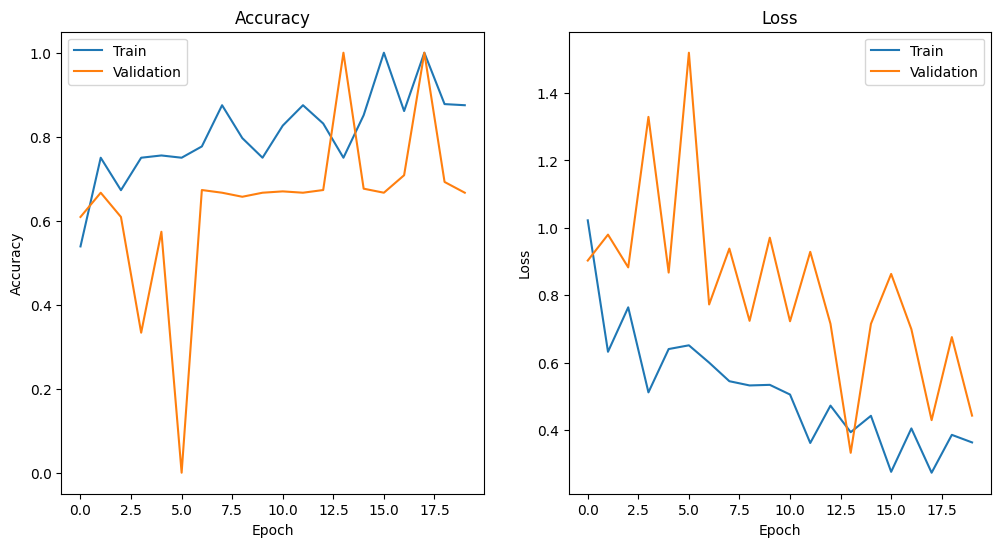

In [10]:
# Save the Model
model.save(r'C:\Users\Bhargav\Desktop\archive (2)\Data\trained_lung_cancer_model.h5')

# Plot Training and Validation Accuracy/Loss
def display_training_curves(training, validation, title, subplot):
    plt.subplot(subplot)
    plt.plot(training)
    plt.plot(validation)
    plt.title(title)
    plt.ylabel(title)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

plt.figure(figsize=(12, 6))
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 121)
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 122)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa


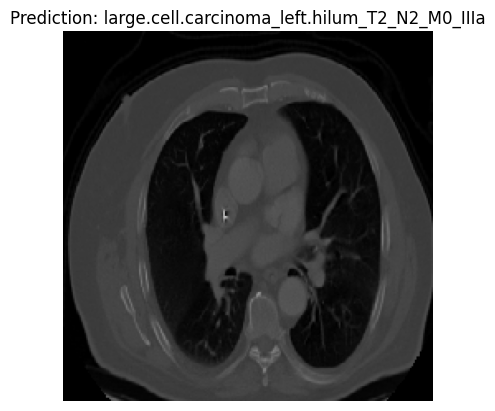

In [ ]:
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Predict New Images
img_path = r'C:\Users\Bhargav\Desktop\archive (2)\Data\train\large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa\000033 (4).png'  # Replace with your image path
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])
class_labels = list(train_generator.class_indices.keys()) 
predicted_label = class_labels[predicted_class]

print(f"Predicted Class: {predicted_label}")

plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Prediction: {predicted_label}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Predicted Class: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa


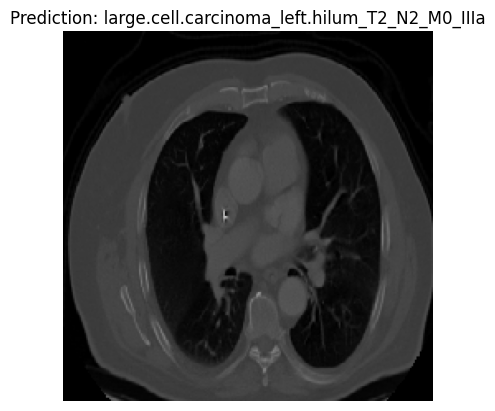

In [15]:
# Predict New Images
img_path = r'C:\Users\Bhargav\Desktop\archive (2)\Data\train\large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa\000033 (4).png'  # Replace with your image path
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(f"Predicted Class: {predicted_label}")

plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Prediction: {predicted_label}")
plt.axis('off')
plt.show()
